In [1]:
import exmel
from exmel.alignment import FrozenMatch

dataset = exmel.Dataset("dataset")

In [2]:
song_name_to_candidates: dict[str, list[FrozenMatch]] = {}
score_model = exmel.DummyModel()
for song in dataset:
    candidates = exmel.align(
        song.melody,
        song.performance,
        exmel.AlignConfig(score_model=score_model, candidate_min_score=0, hop_length=1),
        skip_wisp=True)
    song_name_to_candidates[song.name] = candidates

Scanning alignments: 100%|██████████| 535/535 [00:35<00:00, 15.04it/s]


In [7]:
from dataclasses import dataclass
from tqdm.auto import tqdm
import exmel

@dataclass(frozen=True, slots=True)
class Detection:
    tp: int
    fp: int
    start: float
    end: float

detections: dict[str, list[Detection]] = {}
for song in tqdm(dataset):
    detections[song.name] = []
    for match in song_name_to_candidates[song.name]:
        assert song.ground_truth is not None
        tp, fp = exmel.tp_fp(match, song.ground_truth)
        detections[song.name].append(
            Detection(tp, fp, match.start, match.end))

  0%|          | 0/17 [00:00<?, ?it/s]

# Real tp-fp

In [3]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    score_model.load_song_stats(song_stats(song.melody, song.performance))
    candidates = song_name_to_candidates[song.name]
    scores: list[float] = []
    for c in candidates:
        assert song.ground_truth is not None
        tp, fp = exmel.tp_fp(c, song.ground_truth)
        scores.append(tp-fp)
    name_to_scores[song.name] = scores

  0%|          | 0/17 [00:00<?, ?it/s]

In [4]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = exmel.evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

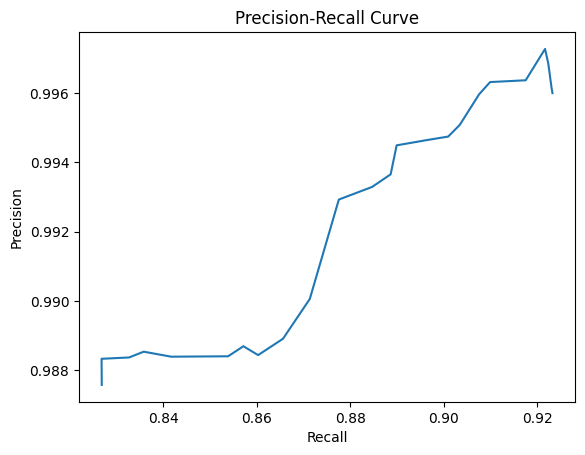

In [5]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [6]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=1, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=2, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=3, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=4, f1=0.957593118549517, pre=0.996000926885767, rec=0.9232043386284174
p=5, f1=0.9575511082385807, pre=0.9961525308677404, rec=0.9230052377337385
p=6, f1=0.9575511082385807, pre=0.9961525308677404, rec=0.9230052377337385
p=7, f1=0.9575511082385807, pre=0.9961525308677404, rec=0.9230052377337385
p=8, f1=0.9575511082385807, pre=0.9961525308677404, rec=0.9230052377337385
p=9, f1=0.9574452482425111, pre=0.9968502851216979, rec=0.9223140053254463
p=10, f1=0.9572324720668054, pre=0.9972783900491119, rec=0.9216169901648948
p=11, f1=0.9544639906658406, pre=0.9963727357064606, rec=0.9174760925151231
p=12, f1=0.9500140697841374, pre=0.9963207563088533, rec=0.9098651376052027
p=13, f1=0.9484881749225719, pre

In [9]:
from exmel.event import MelEvent
from exmel.sequence import MelodyLike, Melody
from exmel.eval import EvaluationResult
from exmel.io import PathLike

def evaluate_melody(
    gt: MelodyLike,
    pred: MelodyLike,
    tolerance: float = 0.1,
    modulo: bool = True,
    plot: bool = True,
    save_path: PathLike | None = None,
) -> EvaluationResult:
    """
    Evaluate the accuracy of a predicted melody against a ground truth melody.
    Creates a piano roll visualization with color coding for tp/fp/fn.
    
    Args:
        gt: Ground truth melody
        pred: Predicted melody
        tolerance: Time tolerance for matching notes (seconds)
        modulo: Whether to use modulo 12 for note matching
        plot: Whether to plot the evaluation result
        save_path: Optional path to save the visualization plot
    """
    gt = Melody(gt)
    pred = Melody(pred)

    if modulo:
        gt %= 12
        pred %= 12
    
    # Track which notes are tp, fp, fn for visualization
    tp_notes: list[MelEvent] = []
    fp_notes: list[MelEvent] = []
    fn_notes: list[MelEvent] = []
    
    # Find true positives and mark matched gt notes
    matched_gt_indices = set()
    for p_event in pred:
        nearest = gt.nearest(p_event)
        if nearest is not None:
            if abs(p_event.time - nearest.time) <= tolerance:
                tp_notes.append(p_event)
            else:
                fp_notes.append(p_event)
        else:
            fp_notes.append(p_event)
    
    # Find false negatives (unmatched gt notes)
    for g_event in gt:
        nearest = pred.nearest(g_event)
        if nearest is None or abs(g_event.time - nearest.time) > tolerance:
            fn_notes.append(g_event)
    
    # Calculate metrics
    tp = len(tp_notes)
    fp = len(fp_notes)
    fn = len(fn_notes)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Create piano roll visualization
    if plot:
        fig = None
    else:
        fig = None
    
    return EvaluationResult(tp, fp, fn, precision, recall, f1_score, fig)

In [10]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

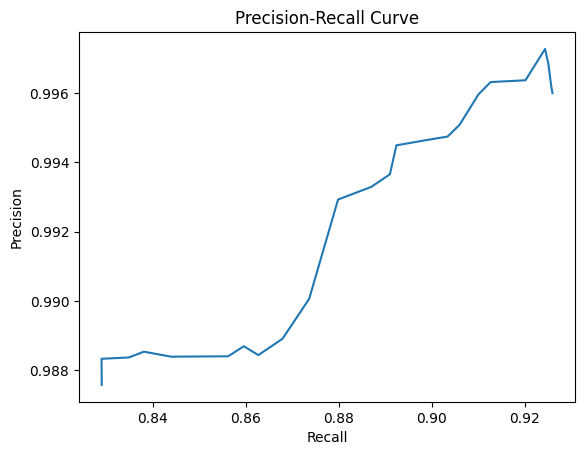

In [11]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [12]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.9590800356944861, pre=0.996000926885767, rec=0.9259604827894587
p=1, f1=0.9590800356944861, pre=0.996000926885767, rec=0.9259604827894587
p=2, f1=0.9590800356944861, pre=0.996000926885767, rec=0.9259604827894587
p=3, f1=0.9590800356944861, pre=0.996000926885767, rec=0.9259604827894587
p=4, f1=0.9590800356944861, pre=0.996000926885767, rec=0.9259604827894587
p=5, f1=0.9590396553423797, pre=0.9961525308677404, rec=0.9257481116627331
p=6, f1=0.9590396553423797, pre=0.9961525308677404, rec=0.9257481116627331
p=7, f1=0.9590396553423797, pre=0.9961525308677404, rec=0.9257481116627331
p=8, f1=0.9590396553423797, pre=0.9961525308677404, rec=0.9257481116627331
p=9, f1=0.9589373855274576, pre=0.9968502851216979, rec=0.9250657889347771
p=10, f1=0.9587248694543717, pre=0.9972783900491119, rec=0.9243686844344875
p=11, f1=0.9559368730628798, pre=0.9963727357064606, rec=0.9201577522456664
p=12, f1=0.9515716555218778, pre=0.9963207563088533, rec=0.912663823792735
p=13, f1=0.9499174068250833,

# With R

In [13]:
from tqdm.auto import tqdm
from exmel.sequence import song_stats

R = 0.97

name_to_scores: dict[str, list[float]] = {}
for song in tqdm(dataset):
    score_model.load_song_stats(song_stats(song.melody, song.performance))
    candidates = song_name_to_candidates[song.name]
    dts = detections[song.name]
    scores: list[float] = []
    for c, d in zip(candidates, dts):
        tp, fp = d.tp, d.fp
        scores.append((2-R)*tp - R*fp)
    name_to_scores[song.name] = scores

  0%|          | 0/17 [00:00<?, ?it/s]

In [14]:
from itertools import product
from exmel.wisp import weighted_interval_scheduling
from exmel.alignment import Alignment, concat_matches
import numpy as np


pen_min_tuple = list(product([0], range(31)))

f1_list: list[float] = []
precision_list: list[float] = []
recall_list: list[float] = []

for p, m in pen_min_tuple:
    f1_score = 0
    precision = 0
    recall = 0
    for song in tqdm(dataset, desc=f"{p=}, {m=}"):
        scores = np.array(name_to_scores[song.name]) - p
        candidates = song_name_to_candidates[song.name]
        updated_candidates: list[FrozenMatch] = []
        for candidate, score in zip(candidates, scores):
            if score >= m:
                updated_candidates.append(candidate.update_score(score))
        candidates = updated_candidates
        opt_score, opt_subset = weighted_interval_scheduling(
            candidates, return_subset=True, verbose=False)
        discarded_matches = [match for match in candidates if match not in opt_subset]
        concat_events = concat_matches(opt_subset)
        alignment = Alignment(concat_events, opt_subset, discarded_matches, opt_score,
                        sum(match.sum_miss for match in opt_subset),
                        sum(match.sum_error for match in opt_subset))
        assert song.ground_truth is not None
        result = evaluate_melody(song.ground_truth, alignment.events, plot=False)
        f1_score += result.f1_score
        precision += result.precision
        recall += result.recall
    f1_score /= len(dataset)
    precision /= len(dataset)
    recall /= len(dataset)
    f1_list.append(f1_score)
    precision_list.append(precision)
    recall_list.append(recall)

p=0, m=0:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=1:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=2:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=3:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=4:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=5:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=6:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=7:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=8:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=9:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=10:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=11:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=12:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=13:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=14:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=15:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=16:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=17:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=18:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=19:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=20:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=21:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=22:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=23:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=24:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=25:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=26:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=27:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=28:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=29:   0%|          | 0/17 [00:00<?, ?it/s]

p=0, m=30:   0%|          | 0/17 [00:00<?, ?it/s]

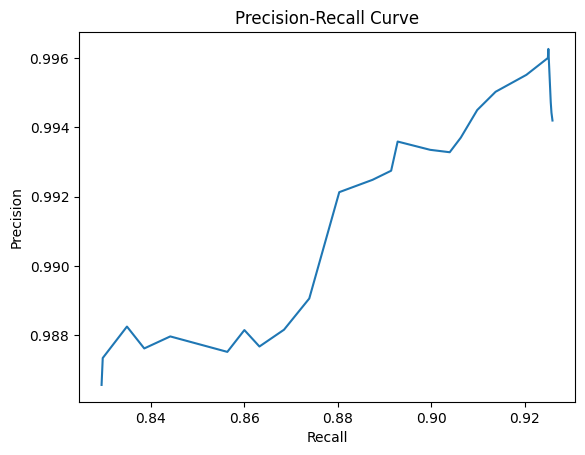

In [15]:
from matplotlib import pyplot as plt

plt.plot(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [16]:
for p, f1, pre, rec in zip(range(31), f1_list, precision_list, recall_list):
    print(f"{p=}, {f1=}, {pre=}, {rec=}")

p=0, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=1, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=2, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=3, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=4, f1=0.9582755087520316, pre=0.9941980488022901, rec=0.9259363690809265
p=5, f1=0.9582687022604259, pre=0.9944225393140584, rec=0.9257203708089126
p=6, f1=0.9582687022604259, pre=0.9944225393140584, rec=0.9257203708089126
p=7, f1=0.9583106376903028, pre=0.9947279074772103, rec=0.925564799379715
p=8, f1=0.9583106376903028, pre=0.9947279074772103, rec=0.925564799379715
p=9, f1=0.9586962567332246, pre=0.9962663263336807, rec=0.9250552376596105
p=10, f1=0.9585372332462411, pre=0.9960051167857792, rec=0.9249556901420769
p=11, f1=0.9556941606727111, pre=0.9955174939099325, rec=0.9203535979903081
p=12, f1=0.9517409598345546, pre=0.995029142537066, rec=0.9137747110357843
p=13, f1=0.94922457380662